In [76]:
import pandas as pd
from pandas import DataFrame
import numpy as np

df_train = pd.read_csv('/home/zan/Desktop/dl_autoencoder/docs/autoencoder/deceptive_opinion_autoencoder/deceptive_training.csv')
df_test = pd.read_csv('/home/zan/Desktop/dl_autoencoder/docs/autoencoder/deceptive_opinion_autoencoder/deceptive_testing.csv')

In [77]:
### Remplazar los truthful con 0 y deceptive con 1 en la columna deceptive
df_train = df_train.replace({'deceptive': {'truthful': 0, 'deceptive': 1}})
df_test = df_test.replace({'deceptive': {'truthful': 0, 'deceptive': 1}})

In [78]:
## Split train -- validation
split = int(0.8 * len(df_train))
validation_set = df_train[split:]
df_train = df_train[:split]

In [79]:
train_dec_a = df_train.iloc[:, 0]
validation_dec_a = validation_set.iloc[:, 0]
test_dec_a = df_test.iloc[:, 0]

train_dec_a.columns = ['train_dec_a']
validation_dec_a.columns = ['validation_dec_a']
test_dec_a.columns = ['test_dec_a']

In [81]:

x_train = ()
y_train = ()

for index, row in df_train.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_train = x_train + (res,)
    y_train = y_train + (row['deceptive'],)

x_validation = ()
y_validation = ()

for index, row in validation_set.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_validation = x_validation + (res,)
    y_validation = y_validation + (row['deceptive'],)

x_test = ()
y_test = ()

for index, row in df_test.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_test = x_test + (res,)
    y_test = y_test + (row['deceptive'],)


In [82]:
import numpy as np
x_train, y_train = np.asarray(x_train), np.asarray(y_train)
x_validation, y_validation = np.asarray(x_validation), np.asarray(y_validation)
x_test, y_test = np.asarray(x_test), np.asarray(y_test)

x_train = x_train.astype('float32')
x_validation = x_validation.astype('float32')
x_test = x_test.astype('float32')

In [83]:
x_validation.shape

(120, 200)

In [84]:
# reshape inputs for LSTM [samples, timesteps, features]
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1]) # X_train 
print("Training data shape:", x_train.shape)
x_validation = x_validation.reshape(x_validation.shape[0], 1, x_validation.shape[1]) # X_train 
print("Validation data shape:", x_validation.shape)
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])     # X_test 
print("Test data shape:", x_test.shape)

Training data shape: (477, 1, 200)
Validation data shape: (120, 1, 200)
Test data shape: (198, 1, 200)


## Primer MODELO -- mediante LSTM

In [86]:
## Autoencoder simple 

import keras
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras.utils import plot_model
from keras import backend as BE
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True,  
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(32, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

## PRIMER Modelo LSTM -- utilizando el Keras Tuner

In [ ]:
## Aparte del modelo vamos a definir los hiperparametros construyendo el hypermodelo
## Vamos a utilizar o bien una funccion builder o utilizar una subclase HyperModel usando la Keras Tuner 

import keras
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras.utils import plot_model
from keras import backend as BE
from keras import regularizers
import kerastuner as kt

import numpy as np
import matplotlib.pyplot as plt
def build_model(hp):
    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))
    #  for x in range(hp.Int('conv_blocks', 3, 5, default=3)): ## multiples capas de tipo conv blocks
    filters = hp.Int('units', min_value = 16, max_value = 128, step=16)
    L1 = LSTM(filters, activation='relu', return_sequences=True, 
            kernel_regularizer=regularizers.l2(0.00))(inputs)

    filters_2 = int(filters / 4)
    L2 = LSTM(filters_2, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(x_train.shape[1])(L2)
    L4 = LSTM(filters_2, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(filters, activation='relu', return_sequences=True)(L4) 

    output = TimeDistributed(Dense(x_train.shape[2]))(L5)    

    model = Model(inputs, output)
    model.compile(
        optimizer=keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, 1e-1)),
        loss='mae', 
        metrics=['mae', 'mse', 'mape', 'msle', 'cosine_proximity'])

    model.summary()

    return model 

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=30,
    hyperband_iterations=2)

In [ ]:
tuner.search(x_train, epochs = 10, validation_data = x_test, verbose = 1, shuffle=False)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
model = tuner.hypermodel.build(best_hps)
model.fit(x_train, epochs = 10, validation_data = x_test)

## Limite Keras Tuner

In [88]:
# create the autoencoder model
model = autoencoder_model(x_train)
model.compile(optimizer='adamax', loss='mae', metrics=['mae', 'mse', 'mape', 'msle', 
                                                     'cosine_proximity']) #Error absoluto medio (mae), MeanSquaredError mse
model.summary()


Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1, 200)]          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 1, 32)             29824     
_________________________________________________________________
lstm_13 (LSTM)               (None, 4)                 592       
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 1, 4)              144       
_________________________________________________________________
lstm_15 (LSTM)               (None, 1, 32)             4736      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 200)           

In [89]:
# collect data across multiple repeats
dtrain = DataFrame()
val = DataFrame()

history = model.fit(x_train, x_train, epochs=30, batch_size=32,
                    validation_data=(x_validation, x_validation), 
                    verbose=0).history
                                                               
dtrain['A'] = history['loss']
val['B'] = history['val_loss']


In [90]:
x_train.shape

(477, 1, 200)

               A
count  30.000000
mean    0.506088
std     0.553298
min     0.176437
25%     0.178900
50%     0.184292
75%     0.585451
max     1.705942


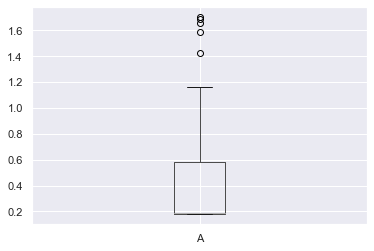

In [91]:
print(dtrain.describe())
dtrain.boxplot()
plt.show()

In [92]:
print("Best MAE on Validation Set =", max(history['val_mae']))

Best MAE on Validation Set = 1.7655991315841675


In [93]:
loss = model.evaluate(x_test, x_test, verbose=0)
print(loss)

[0.16669371724128723, 0.16669371724128723, 0.049334898591041565, 54.23646545410156, 0.005736589897423983, 0.9931493401527405]


In [94]:
for name, value in zip(model.metrics_names, loss):
    print(name, value)

loss 0.16669371724128723
mae 0.16669371724128723
mse 0.049334898591041565
mape 54.23646545410156
msle 0.005736589897423983
cosine_proximity 0.9931493401527405


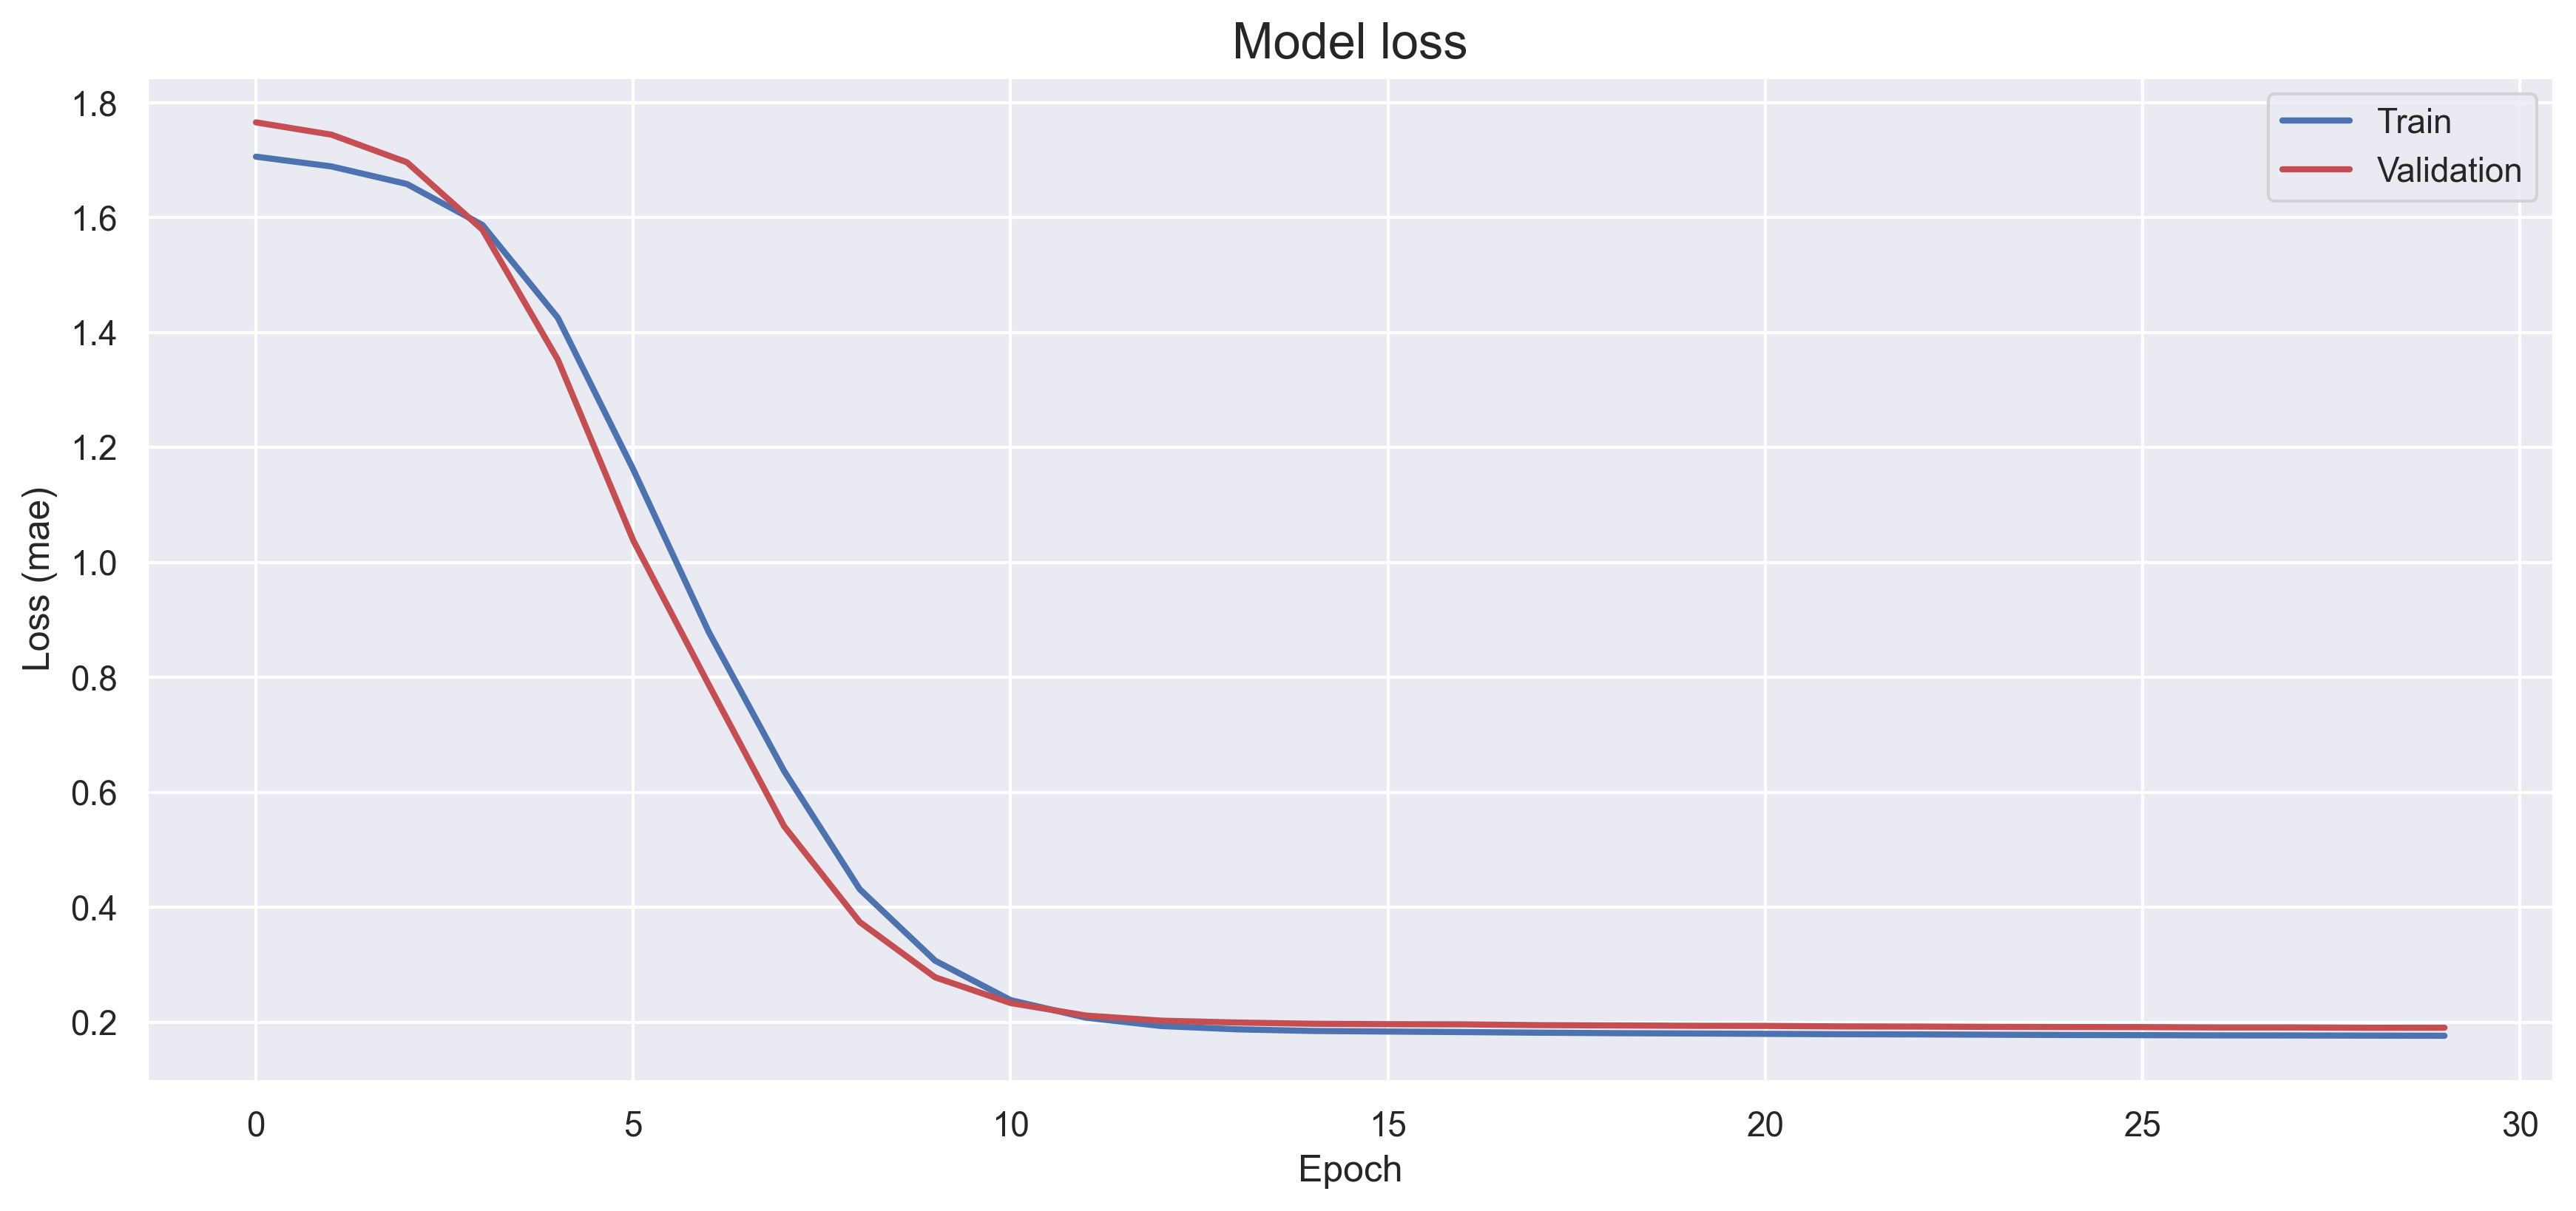

In [95]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

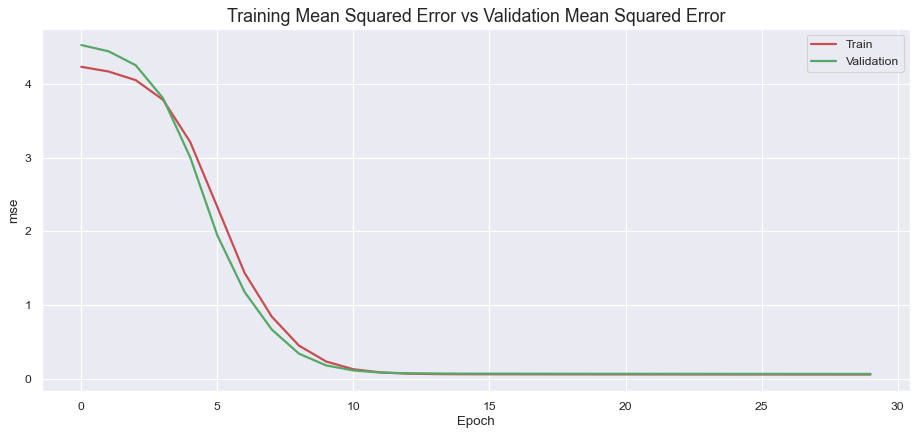

In [96]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['mse'], 'r', label='Train', linewidth=2)
ax.plot(history['val_mse'], 'g', label='Validation', linewidth=2)
ax.set_title('Training Mean Squared Error vs Validation Mean Squared Error', fontsize=16)
ax.set_ylabel('mse')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

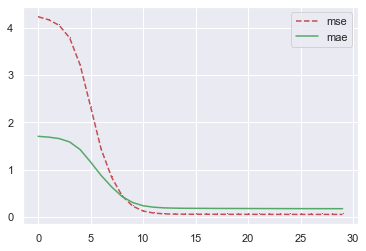

In [97]:
# plot metrics
plt.plot(history['mse'],'r--,', label='mse')
plt.plot(history['mae'],'g', label='mae')
plt.legend(loc='upper right')
plt.show()

"\nXPred = XPred.reshape(XPred.shape[0] * XPred.shape[2], XPred.shape[1])\nXPred = pd.DataFrame(XPred, columns=['text'])\nXPred.index = df_train.index * 200\n\nscored = pd.DataFrame(index=df_train.index)\nXtrain = x_train.reshape(x_train.shape[0] * x_train.shape[2], x_train.shape[1])\nscored['Loss_mae'] = np.mean(np.abs(XPred-Xtrain), axis = 1)\n\n\nplt.figure(figsize=(16,9), dpi= 300)\nplt.title('Loss Distribution', fontsize=16)\nsns.distplot(scored['Loss_mae'], bins = 40, kde= True, color = 'blue')\nplt.xlim([0.001,0.004])\n"

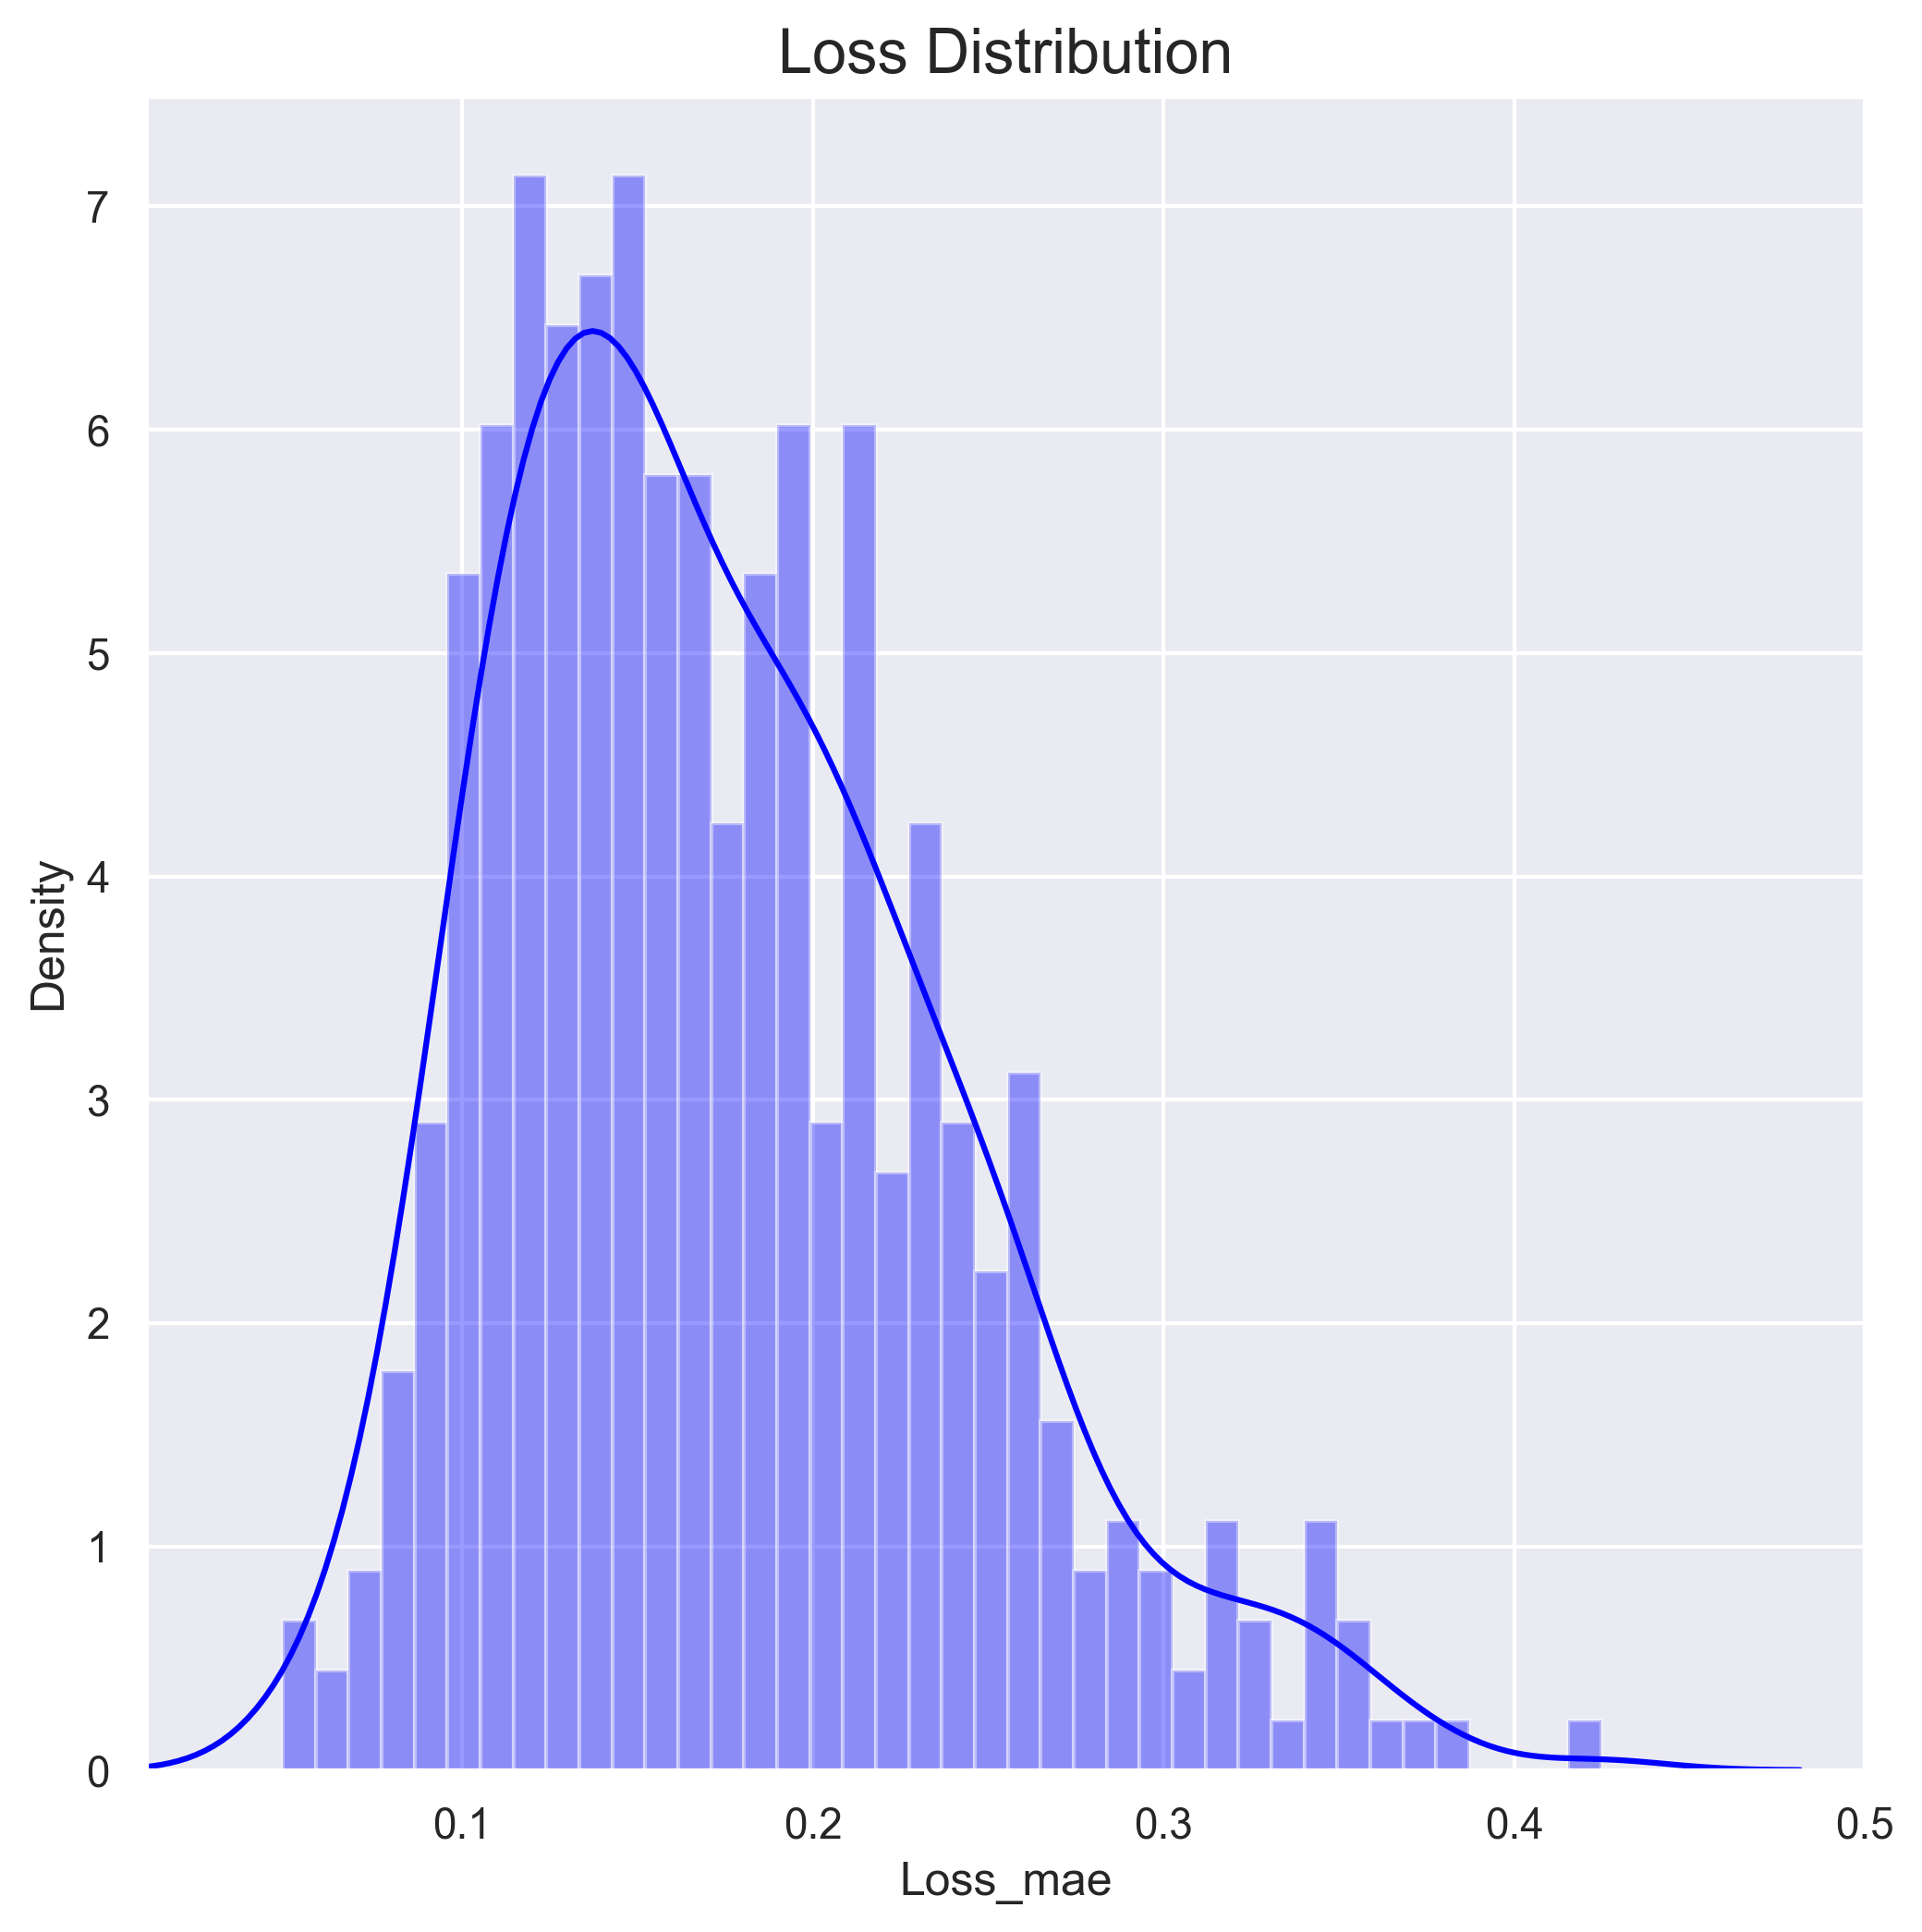

In [99]:
import seaborn as sns
sns.set(color_codes=True)

# plot the loss distribution of the training set
XPred = model.predict(x_train)
XPred = XPred.reshape(XPred.shape[0], XPred.shape[2])

XPred = pd.DataFrame(XPred)

XTrain = x_train.reshape(x_train.shape[0], x_train.shape[2])
scored = pd.DataFrame(index=XPred.index)
scored['Loss_mae'] = np.mean(np.abs(XPred-XTrain), axis = 1)

plt.figure(figsize=(8,8), dpi= 300)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], color = 'blue', bins = 40, kde=True)
plt.xlim([0.01,0.5])
"""
XPred = XPred.reshape(XPred.shape[0] * XPred.shape[2], XPred.shape[1])
XPred = pd.DataFrame(XPred, columns=['text'])
XPred.index = df_train.index * 200

scored = pd.DataFrame(index=df_train.index)
Xtrain = x_train.reshape(x_train.shape[0] * x_train.shape[2], x_train.shape[1])
scored['Loss_mae'] = np.mean(np.abs(XPred-Xtrain), axis = 1)


plt.figure(figsize=(16,9), dpi= 300)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 40, kde= True, color = 'blue')
plt.xlim([0.001,0.004])
"""

In [106]:
# calculate the loss on the test set
XPred = model.predict(x_test)
XPred = XPred.reshape(XPred.shape[0], XPred.shape[2])
XPred = pd.DataFrame(XPred)

scored = pd.DataFrame(index=XPred.index)
Xtest = x_test.reshape(x_test.shape[0], x_test.shape[2])

scored['Loss_mae'] = np.mean(np.abs(XPred-Xtest), axis = 1)
scored['Threshold'] = 0.2
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
0,0.127326,0.2,False
1,0.095733,0.2,False
2,0.173271,0.2,False
3,0.210257,0.2,True
4,0.115481,0.2,False


In [107]:
scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Loss_mae   198 non-null    float32
 1   Threshold  198 non-null    float64
 2   Anomaly    198 non-null    bool   
dtypes: bool(1), float32(1), float64(1)
memory usage: 2.6 KB


In [108]:
data_filter = scored[scored['Anomaly'] == True]
data_filter.head(100)

,Loss_mae,Threshold,Anomaly
3,0.210257,0.2,True
5,0.211125,0.2,True
11,0.257248,0.2,True
13,0.235546,0.2,True
15,0.330882,0.2,True
19,0.201219,0.2,True
21,0.283399,0.2,True
24,0.323435,0.2,True
27,0.238398,0.2,True
29,0.200480,0.2,True


In [109]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(x_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train)

scored_train = pd.DataFrame(index=X_pred_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-XTrain), axis = 1)
scored_train['Threshold'] = 0.2
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:>

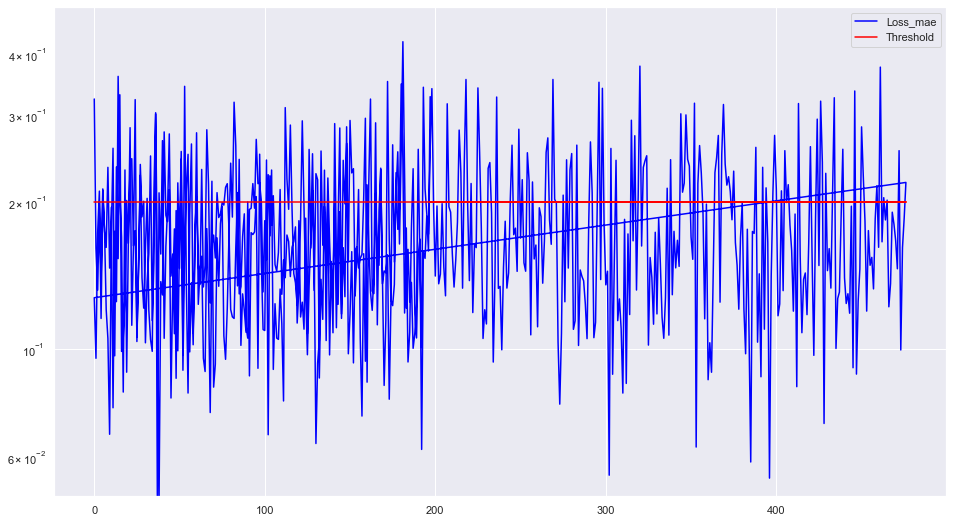

In [110]:
scored.plot(logy=True,  figsize=(16,9), ylim=[5e-2,5e-1], color=['blue','red'])

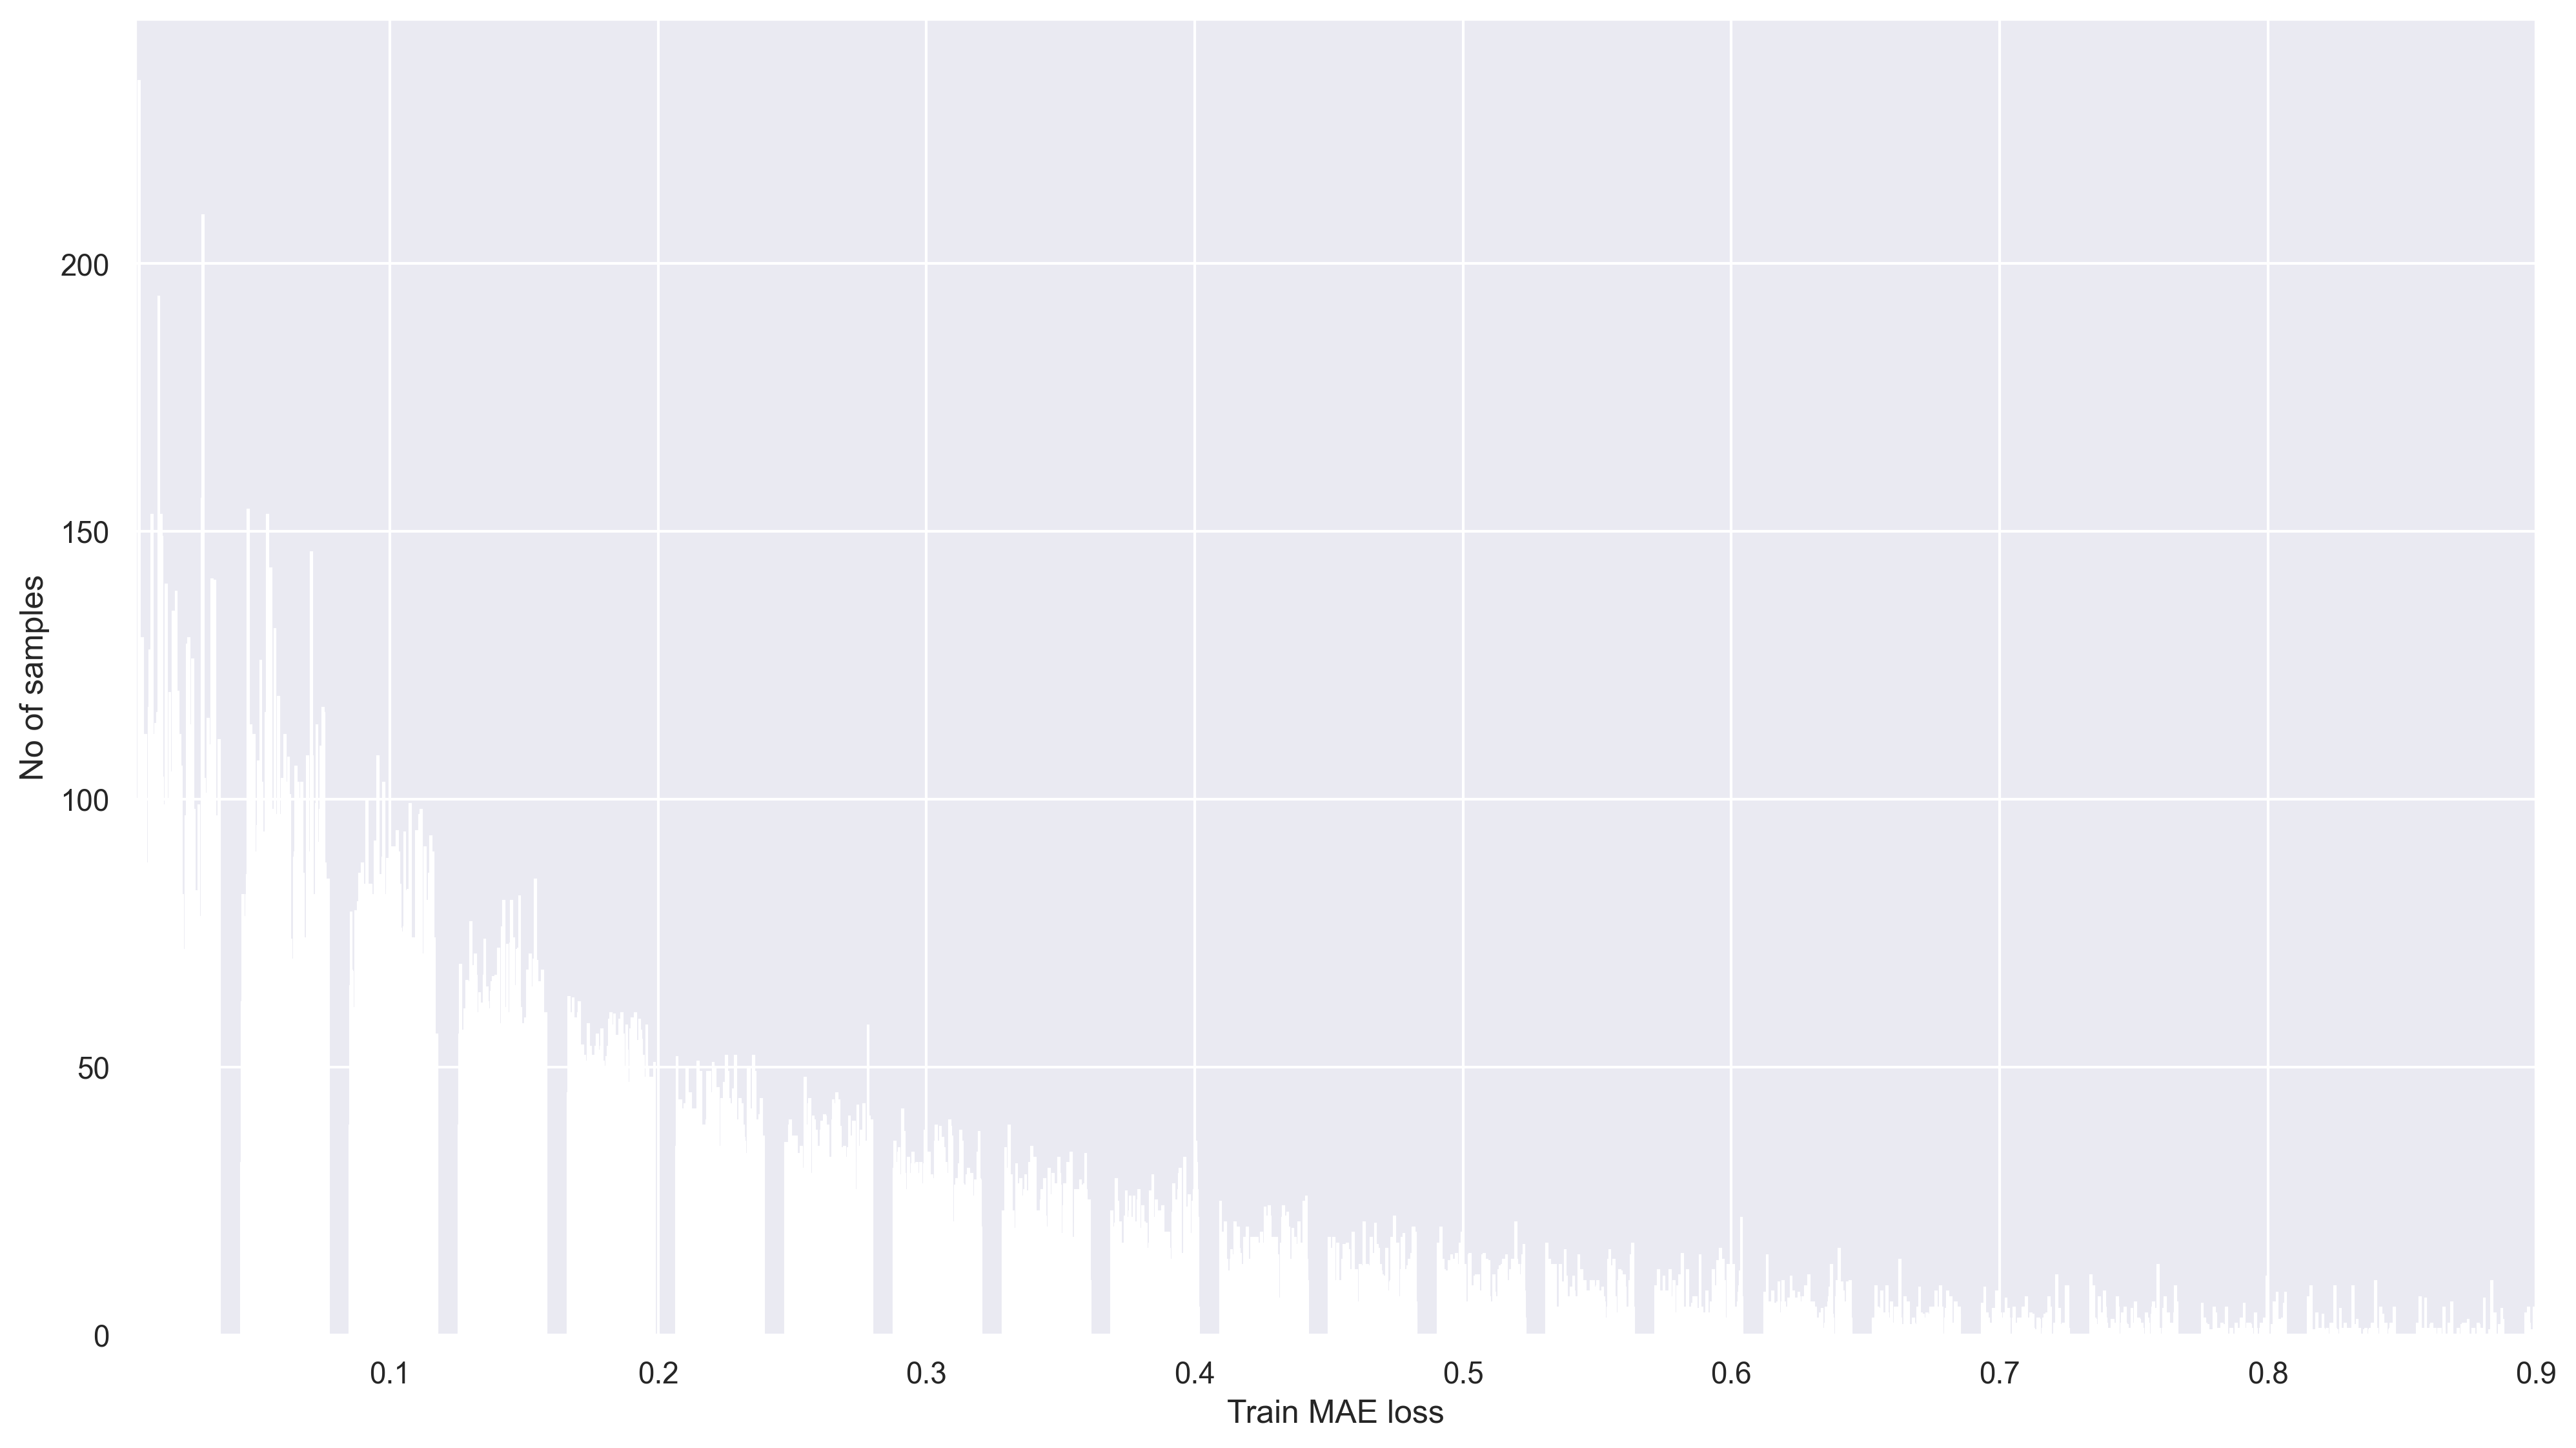

Reconstruction error threshold:  1.6220515


In [114]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
plt.figure(figsize=(16,9), dpi= 300)
plt.hist(train_mae_loss, bins= 40)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.xlim([0.005,0.9])
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

## Determinación de Clasificación. (dataset de train)

In [115]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, cohen_kappa_score, fbeta_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, log_loss
# calculate the loss on the training set
X_pred = model.predict(x_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)

In [116]:
error_df = pd.DataFrame(index=X_pred.index)
Xtrain = x_train.reshape(x_train.shape[0], x_train.shape[2])
error_df['Reconstruction_error'] = np.mean(np.power(X_pred-Xtrain, 2), axis = 1)
error_df['True_class'] = train_dec_a
error_df.head()

,Reconstruction_error,True_class
0,0.167365,0
1,0.040895,0
2,0.026131,0
3,0.063993,0
4,0.031530,0


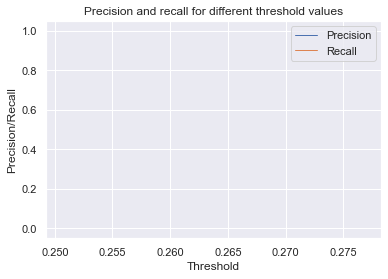

In [117]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Text(0.5, 0, 'False Positive Rate')

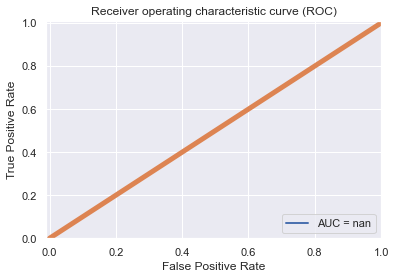

In [118]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

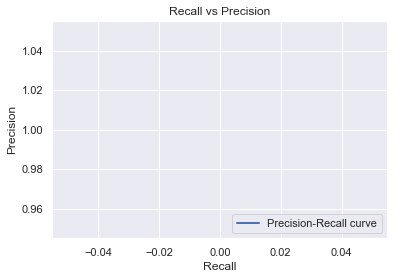

In [119]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=2, label='Precision-Recall curve')
plt.legend(loc='lower right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

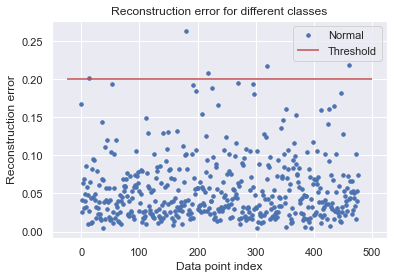

In [120]:
threshold_fixed = 0.2
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "ANOMALY" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

## Confusion Matrix


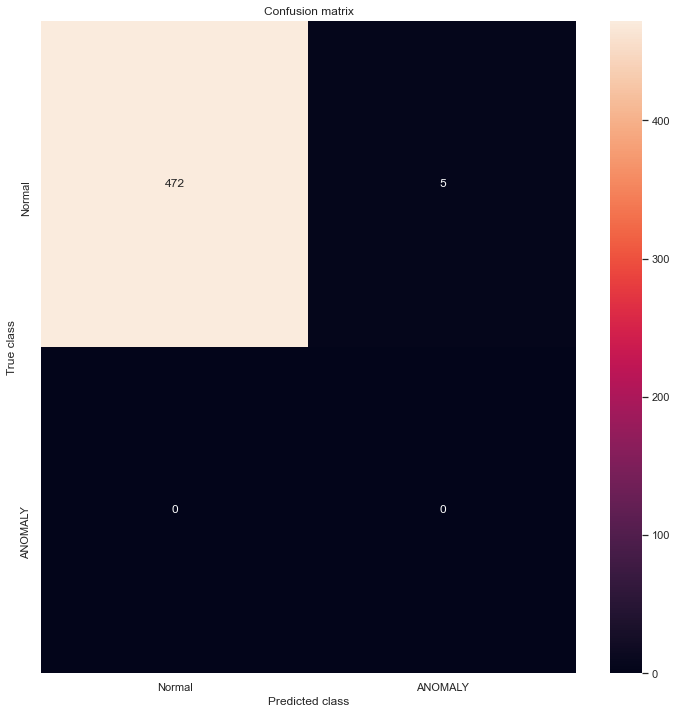

In [121]:
LABELS = ["Normal","ANOMALY"]
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Text(0.5, 1.0, 'Reconstruction error - Train set')

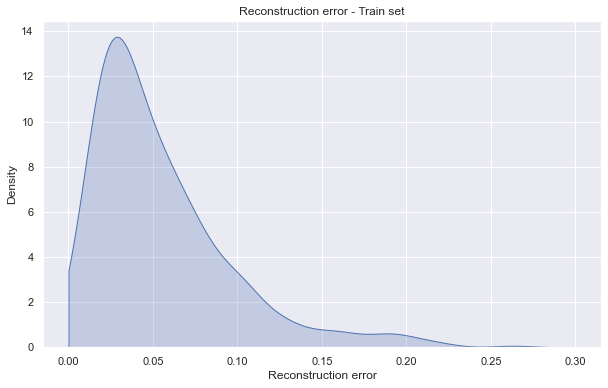

In [122]:
plt.figure(figsize=(10,6))
sns.kdeplot(error_df.Reconstruction_error[error_df.True_class==0], label='Normal', shade=True, clip=(0,10))
sns.kdeplot(error_df.Reconstruction_error[error_df.True_class==1], label='ANOMALY', shade=True, clip=(0,10))
plt.xlabel('Reconstruction error')
plt.title('Reconstruction error - Train set')

## Determinación de Clasificación. Test

In [123]:
# calculate the loss on the test set
X_pred = model.predict(x_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)


In [124]:
error_df = pd.DataFrame(index=X_pred.index)
Xtest = x_test.reshape(x_test.shape[0], x_test.shape[2])
error_df['Reconstruction_error'] = np.mean(np.power(X_pred-Xtest, 2), axis = 1)
error_df['True_class'] = test_dec_a
error_df.head()

,Reconstruction_error,True_class
0,0.024971,0
1,0.014253,0
2,0.044322,0
3,0.069924,0
4,0.021039,0


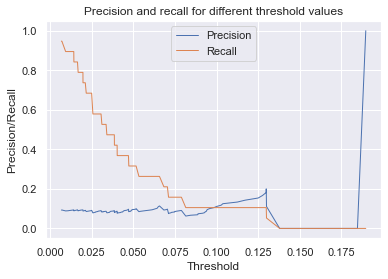

In [125]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## ROC CURVE CHECK

Text(0.5, 0, 'False Positive Rate')

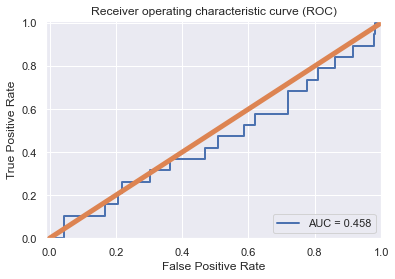

In [126]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## RECALL VS PRECISION THRESHOLDING

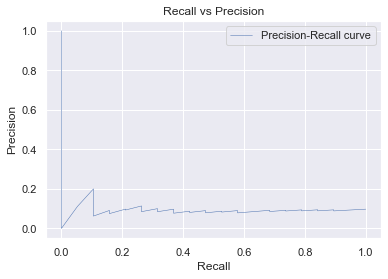

In [127]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=0.5, label='Precision-Recall curve')
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## Reconstruction Error vs Threshold Check

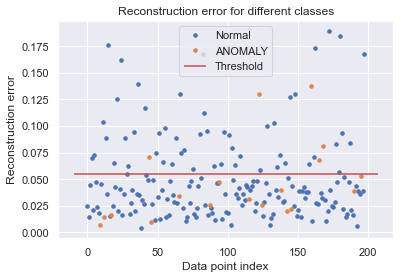

In [139]:
threshold_fixed = 0.055
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "ANOMALY" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

## Confusion Matrix

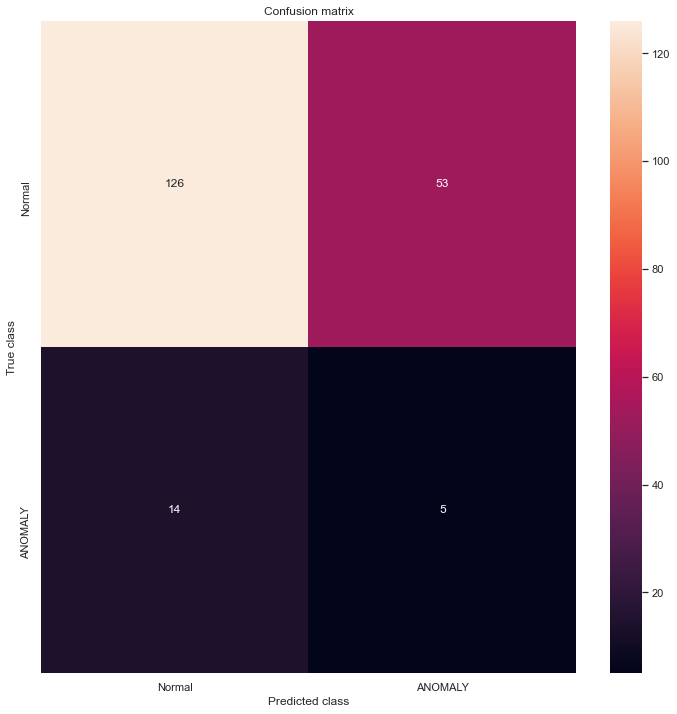

In [140]:
LABELS = ["Normal","ANOMALY"]

pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## MODEL STATS

In [141]:
def print_stats(ytest, ypred):
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    ll = log_loss(ytest, ypred)
    print("Log Loss: {}".format(ll))
    print(' ')
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

In [142]:
print_stats(error_df.True_class, pred_y)

Accuracy: 0.66162, Cohen's Kappa Score: -0.01718
Log Loss: 11.687577763246546
 
Confusion Matrix:
[[126  53]
 [ 14   5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       179
           1       0.09      0.26      0.13        19

    accuracy                           0.66       198
   macro avg       0.49      0.48      0.46       198
weighted avg       0.82      0.66      0.73       198



In [134]:
p = precision_score(error_df.True_class, pred_y)
r = recall_score(error_df.True_class, pred_y)
f = fbeta_score(error_df.True_class, pred_y, beta= 2)
print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))

Result: p=0.095, r=0.316, f=0.216


## Segundo modelo -- capas Dense (redes NN)

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
#Capa input
model.add(layers.Input(shape=(x_train.shape[1],x_train.shape[2])))
#Capas ocultas
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(layers.Dense(32, activation = "relu"))
model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
#Capa salida
model.add(layers.Dense(x_train.shape[2], activation = "sigmoid"))
model.summary()

In [ ]:
model.compile(
 optimizer = "adam",
 loss = "mae",
 metrics = ['mae', 'mse']
)

In [ ]:
history = model.fit(
 x_train, x_train,
 epochs= 50,
 batch_size = 32,
 validation_split= 0.1,
)
print("Validation loss:", np.mean(results.history["val_loss"]))

In [ ]:
etrain = DataFrame()
etrain['B'] = history.history['loss']
print(etrain.describe())
etrain.boxplot()
plt.show()

In [ ]:
print("Best MAE on Validation Set =", max(history.history['val_mae']))

In [ ]:
loss = model.evaluate(x_test, x_test, verbose=0)
print(loss)

In [ ]:
for name, value in zip(model.metrics_names, loss):
    print(name, value)

## Tercer modelo -- Variational Autoencoder

In [ ]:
## VAE -- utilizando resampling del espacio latente
import keras
from keras import layers,models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1DTranspose, Input
from keras import backend as BE


original_dim = 200
intermediate_dim = 20
latent_dim = 15 

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [ ]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = BE.random_normal(shape=(BE.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + BE.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - BE.square(z_mean) - BE.exp(z_log_sigma)
kl_loss = BE.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = BE.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [ ]:
history = vae.fit(x_train, x_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(x_test, x_test))

In [ ]:
import matplotlib.pyplot as plt


history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
## Creamos el plot para mostrar el loss y val_loss durante los epochs

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [ ]:
"""
import keras
from keras import layers,models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1DTranspose, Input

model = keras.Sequential([
    layers.Input(shape=(x_train.shape[0],x_train.shape[1])),
    layers.Conv1D( 32, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Dropout(rate=0.2),
    layers.Conv1D( 16, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Conv1DTranspose( 16, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Dropout(rate=0.2),
    layers.Conv1DTranspose( 32, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Conv1DTranspose(1, 7, padding="same"),
])
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = "mse")
model.summary()
"""

In [ ]:
"""
history = model.fit(
    x_train,
    x_train,
    epochs = 50,
    batch_size = 32,
    validation_split = 0.1,
    callbacks = [ 
        keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode="min")
    ]
)
"""